In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
from targetDB import target_descriptors as td
from targetDB.utils import gene2id as g2id
import sqlite3

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedShuffleSplit

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Path to the TargetDB sqlite database (Please change to the according path)
targetDB_path = "C://Users//sdecesco//Documents//databases/TargetDB_20_12_19.db"
#targetDB_path = "C:\\Path\\to\\DB\\TargetDB_20_02_19.db"

con = sqlite3.connect(targetDB_path)
query = "SELECT Target_id from Targets"
# Collect all targets from TargetDB
undrugged_id = pd.read_sql(query,con=con)

# Collect data from DGIdb (actionnable and druggable genome)

df = pd.read_excel('categories_dgid_13_01_2020.xls')
df_druggable = df[df.category=='DRUGGABLE GENOME']
df_actionnable = df[df.category=='CLINICALLY ACTIONABLE']

druggable_genome_id = g2id.gene_to_id(list(df_druggable.entrez_gene_symbol),targetDB_path=targetDB_path)
druggable_genome_id_list = "','".join(druggable_genome_id.uniprot_ids.astype(str))
druggable_genome_id_list = druggable_genome_id_list.replace('[\'', '').replace('\']', '')
druggable_genome = td.get_descriptors_list(druggable_genome_id_list, targetdb=targetDB_path)

drugged_genome_id = g2id.gene_to_id(list(df_actionnable.entrez_gene_symbol),targetDB_path=targetDB_path)
drugged_genome_id_list = "','".join(drugged_genome_id.uniprot_ids.astype(str))
drugged_genome_id_list = drugged_genome_id_list.replace('[\'', '').replace('\']', '')
drugged_id = td.get_descriptors_list(drugged_genome_id_list, targetdb=targetDB_path)


# Remove from the undrugged list all the actionnable and druggable targets from DGIdb
undrugged_id = undrugged_id[~undrugged_id['Target_id'].isin(drugged_id['Target_id'])]
undrugged_id = undrugged_id[~undrugged_id['Target_id'].isin(druggable_genome['Target_id'])]
# Write the list of all the actionnable targets and randomly selected 400 targets 
# in the undrugged list to be used as the non-tractable list in the training of the model 
undrugged_id_txt = "','".join(list(undrugged_id.sample(400,random_state=42).Target_id))
drugged_id_txt = "','".join(list(drugged_id.Target_id))

[NAME CONVERSION]: Converting gene names into IDs (Uniprot,Ensembl,HGNC)
[NAME CONVERSION]: Conversion Done
[NAME CONVERSION]: Converting gene names into IDs (Uniprot,Ensembl,HGNC)
[NAME CONVERSION]: Conversion Done


In [4]:
data_drug = td.get_descriptors_list(drugged_id_txt,targetdb=targetDB_path)
data_undrug = td.get_descriptors_list(undrugged_id_txt,targetdb=targetDB_path)

drug = td.target_scores(data_drug,mode='list')
undrug = td.target_scores(data_undrug,mode='list')

drug.scores['DRUGGABLE'] = 1
undrug.scores['DRUGGABLE'] = 0
drug.score_components['DRUGGABLE'] = 1
undrug.score_components['DRUGGABLE'] = 0

detailed_scores = pd.concat([drug.score_components,undrug.score_components])
detailed_scores.index = detailed_scores.Target_id
detailed_scores.drop(columns=['Target_id'],inplace=True)
detailed_scores.replace({True:1,False:0},inplace=True)

In [5]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=33)

for train_idx,test_idx in split.split(detailed_scores,detailed_scores['DRUGGABLE']):
    detailed_score_training = detailed_scores.iloc[train_idx]
    detailed_score_testing = detailed_scores.iloc[test_idx]


# Dropping column to remove risk of prediction leaking
# information_score: is a metric of how much litterature is out there, druggable/drugged target will be more studied than other more obscure targets
# commercial_potent: if a target has some ligand that you can buy it will also be biased for already drugged targets

training_set,training_label = detailed_score_training.drop(columns=['commercial_potent', 'information_score','DRUGGABLE'],axis=1),detailed_score_training['DRUGGABLE']
testing_set,testing_label = detailed_score_testing.drop(columns=['commercial_potent', 'information_score','DRUGGABLE'],axis=1),detailed_score_testing['DRUGGABLE']

training_set = training_set.fillna(0)
testing_set = testing_set.fillna(0)

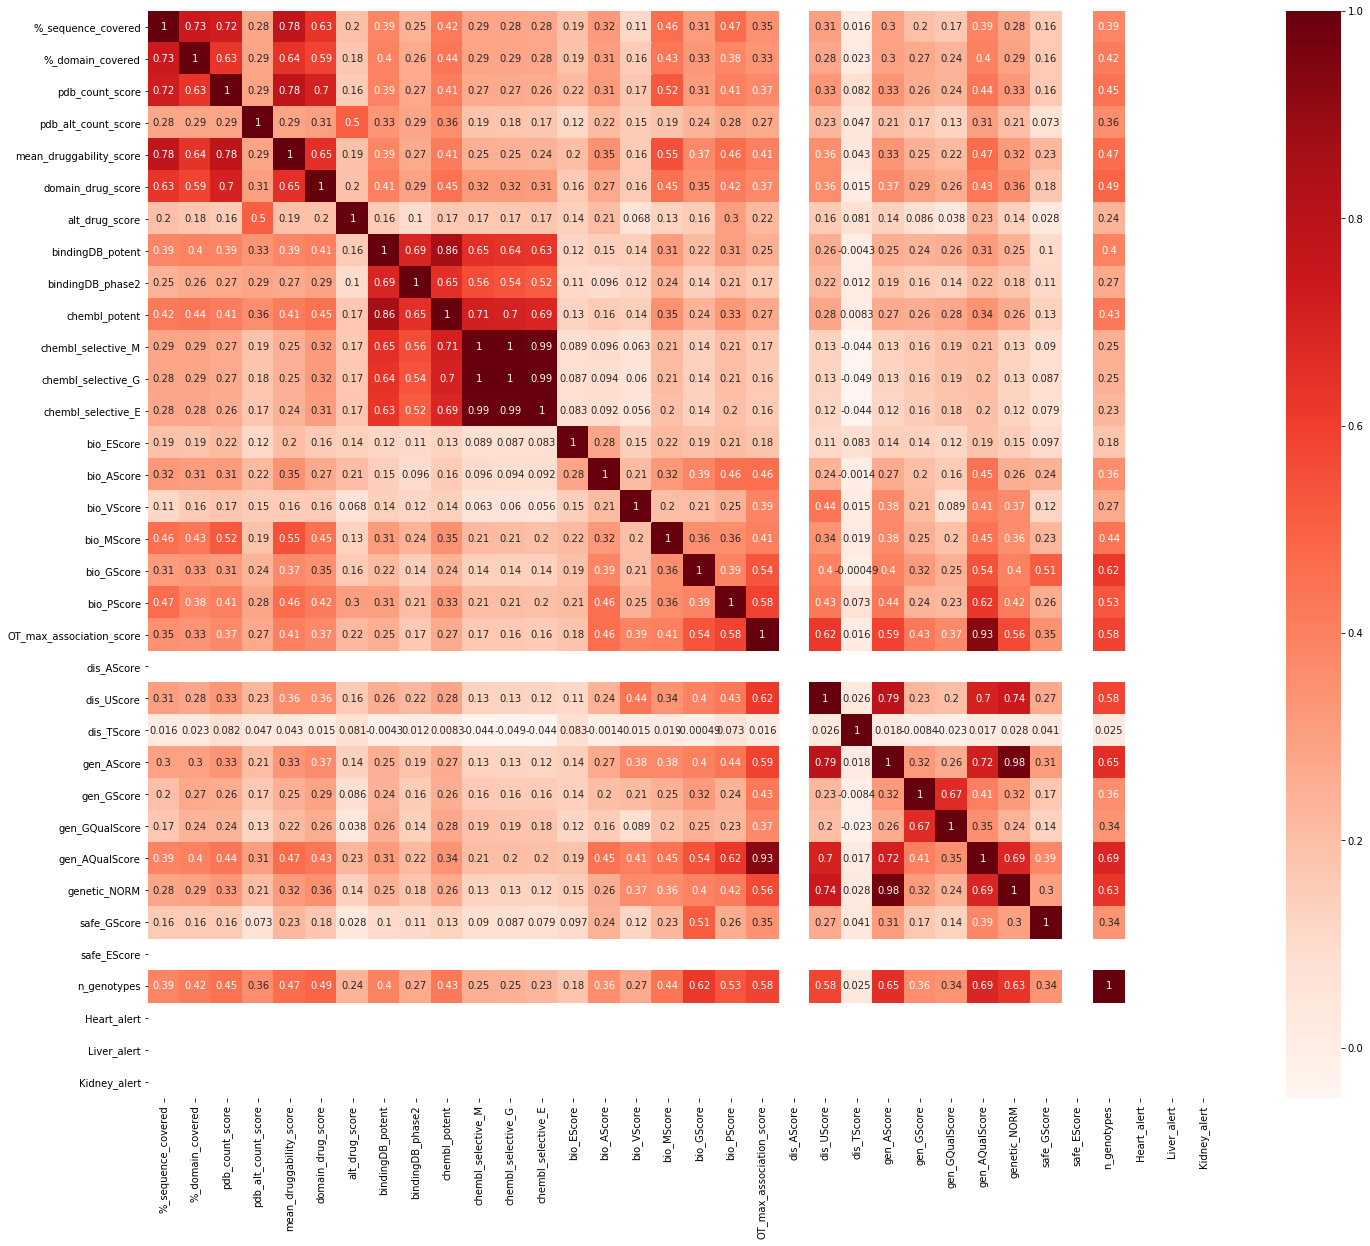

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(24,20))
cor = training_set.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
col_to_drop = ['gen_AQualScore','genetic_NORM']
training_set = training_set.drop(columns=col_to_drop,axis=1)
testing_set = testing_set.drop(columns=col_to_drop,axis=1)

In [8]:
#
# DIVERSE MODEL TRAINING 
#

models_training = {'sgd':SGDClassifier(random_state=42,max_iter=100000,tol=0.001)
                   ,'forest':RandomForestClassifier(n_estimators=1000,random_state=5)
                   ,'svm_prob': SVC(C=1,probability=True,random_state=5)
                   ,'svm': SVC(C=1,random_state=5)
                  ,'Gaussian_process': GaussianProcessClassifier(random_state=5)
                  ,'kNeighbor': KNeighborsClassifier()
                  ,'Naive_bayes':GaussianNB()
                  ,'QDA':QuadraticDiscriminantAnalysis()
                  ,'AdaBoost':AdaBoostClassifier()}
method_dict = {'sgd':'decision_function','forest':'predict_proba','svm_prob':'predict_proba','svm':'decision_function'
               ,'Gaussian_process':'predict_proba','kNeighbor':'predict_proba','Naive_bayes':'predict_proba'
               ,'QDA':'predict_proba','AdaBoost':'predict_proba','NeuralNet':'predict_proba'}


number_of_sub_test = 5
training_results = {}
for k,m in models_training.items():
    if method_dict[k] =='predict_proba':
        training_results[k]={'pred':cross_val_predict(m,training_set,training_label,cv=number_of_sub_test)
                             ,'score':cross_val_predict(m,training_set,training_label,cv=number_of_sub_test,method=method_dict[k])[:,1]
                            ,'prob':cross_val_predict(m,training_set,training_label,cv=number_of_sub_test,method=method_dict[k])}
    elif method_dict[k] == 'score':
        training_results[k]={'pred':cross_val_predict(m,training_set,training_label,cv=number_of_sub_test)
                             ,'score':cross_val_score(m,training_set,training_label,cv=number_of_sub_test)}
    else:
        training_results[k]={'pred':cross_val_predict(m,training_set,training_label,cv=number_of_sub_test)
                             ,'score':cross_val_predict(m,training_set,training_label,cv=number_of_sub_test,method=method_dict[k])}

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

training_eval = {}
for model,results in training_results.items():
    training_eval[model]={'accuracy':round(accuracy_score(training_label,results['pred']),3)
                          ,'precision':round(precision_score(training_label,results['pred']),3)
                          ,'recall':round(recall_score(training_label,results['pred']),3)
                          ,'f1_score':round(f1_score(training_label,results['pred']),3)
                          ,'AU_ROC':round(roc_auc_score(training_label,results['score']),3)}
training_eval_df = pd.DataFrame(training_eval)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-

In [9]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

training_eval_df.T.style.apply(highlight_max)

,AU_ROC,accuracy,f1_score,precision,recall
sgd,0.918,0.788,0.814,0.724,0.929
forest,0.922,0.852,0.849,0.863,0.836
svm_prob,0.916,0.843,0.843,0.84,0.846
svm,0.918,0.843,0.843,0.84,0.846
Gaussian_process,0.908,0.823,0.827,0.809,0.846
kNeighbor,0.865,0.818,0.817,0.822,0.811
Naive_bayes,0.914,0.664,0.508,0.951,0.346
QDA,0.872,0.638,0.444,0.953,0.289
AdaBoost,0.919,0.843,0.839,0.858,0.821


No handles with labels found to put in legend.


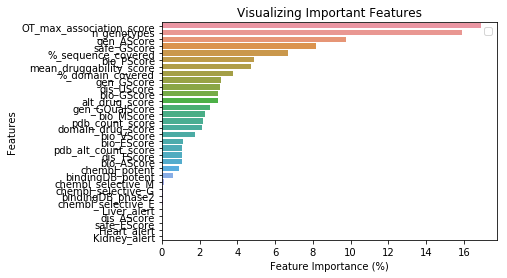

<Figure size 360x720 with 0 Axes>

In [10]:
# Looking at feature importance from the random forest method
# Looking at the results it was decided to remove OT_max_association score 
# and disease association score as these might be too biased towards targets 
# that have application in the clinic already

forest = models_training['forest'].fit(training_set,training_label)

imp = forest.feature_importances_
feature_imp = pd.Series(imp,index=list(training_set.columns)).sort_values(ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=feature_imp*100, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance (%)')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.figure(figsize=(5,10))
plt.show()

In [11]:
training_set.columns

Index(['%_sequence_covered', '%_domain_covered', 'pdb_count_score',
       'pdb_alt_count_score', 'mean_druggability_score', 'domain_drug_score',
       'alt_drug_score', 'bindingDB_potent', 'bindingDB_phase2',
       'chembl_potent', 'chembl_selective_M', 'chembl_selective_G',
       'chembl_selective_E', 'bio_EScore', 'bio_AScore', 'bio_VScore',
       'bio_MScore', 'bio_GScore', 'bio_PScore', 'OT_max_association_score',
       'dis_AScore', 'dis_UScore', 'dis_TScore', 'gen_AScore', 'gen_GScore',
       'gen_GQualScore', 'safe_GScore', 'safe_EScore', 'n_genotypes',
       'Heart_alert', 'Liver_alert', 'Kidney_alert'],
      dtype='object')

In [12]:
col_to_drop2 = ['OT_max_association_score','Heart_alert', 'Liver_alert', 'Kidney_alert','dis_AScore','bio_EScore','safe_EScore','chembl_selective_M', 'chembl_selective_G','chembl_selective_E','bindingDB_phase2']
training_set_focus = training_set.drop(columns=col_to_drop2,axis=1)
testing_set_focus = testing_set.drop(columns=col_to_drop2,axis=1)


In [13]:
training_set_export =  detailed_score_training.drop(columns=['OT_max_association_score', 'Heart_alert', 'Liver_alert', 'Kidney_alert', 'dis_AScore',
                    'bio_EScore', 'safe_EScore', 'chembl_selective_M', 'chembl_selective_G', 'chembl_selective_E',
                    'bindingDB_phase2','commercial_potent', 'information_score','gen_AQualScore', 'genetic_NORM'],axis=1)
training_set_export = training_set_export.fillna(0)

training_set_export.to_json('ml_training_data_13_01_2020.zip',compression='zip')

No handles with labels found to put in legend.


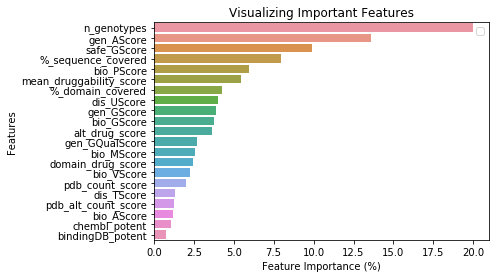

In [14]:
# Looking at feature importance from the random forest method
# Looking at the results it was decided to remove OT_max_association score 
# and disease association score as these might be too biased towards targets 
# that have application in the clinic already

forest = models_training['forest'].fit(training_set_focus,training_label)

imp = forest.feature_importances_
feature_imp = pd.Series(imp,index=list(training_set_focus.columns)).sort_values(ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=feature_imp*100, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance (%)')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 10)]
# Number of features to consider at every split
max_features = [3,4,5,6,7,8,9,10]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3, 4,5,6,7]
# Method of selecting samples for training each tree
random_state = [42]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=1, random_state=42, n_jobs = -1,scoring='f1')

# Fit the random search model
rf_random.fit(training_set_focus, training_label)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.4min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [200, 511, 822, 1133, 1444, 1755, 2066, 2377, 2688, 3000], 'max_features': [3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=1)

In [16]:
rf_random.best_params_

{'random_state': 42,
 'n_estimators': 2066,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': 80}

In [17]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 5)]
# Number of features to consider at every split
max_features = [3,5,8,10]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3, 4]
# Method of selecting samples for training each tree
random_state = [42]

# Create the random grid
exhaustive_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_exhaustive = GridSearchCV(estimator = rf, param_grid = exhaustive_grid, cv = 5, verbose=1, n_jobs = -1,scoring='f1')

# Fit the random search model
rf_exhaustive.fit(training_set_focus, training_label)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 63.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 78.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 94.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 112.8min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 113.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000, 1500, 2000, 2500, 3000], 'max_features': [3, 5, 8, 10], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [18]:
rf_exhaustive.best_params_

{'max_depth': 35,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1500,
 'random_state': 42}

In [20]:
# parameters for the RansomForestClassifier come from random, 
# focus or exhaustive grid search by using the GridSearchCV and RandomizedSearchCV module from scikit-learn
# Here are the parameters that were used for the optimisation:
## Number of trees in random forest
## n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 10)]
## Number of features to consider at every split
## max_features = [3,4,5,6,7,8,9,10]
## Maximum number of levels in tree
## max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
## max_depth.append(None)
## Minimum number of samples required to split a node
## min_samples_split = [2, 5, 10]
## Minimum number of samples required at each leaf node
## min_samples_leaf = [1, 2,3, 4,5,6,7]
## Method of selecting samples for training each tree
## random_state = [42]

random_search = RandomForestClassifier(n_estimators=2066,max_depth=80,max_features=5,min_samples_leaf=1,min_samples_split=10)
grid_exhaustive = RandomForestClassifier(n_estimators=1500,max_depth=35,max_features=5,min_samples_leaf=1,min_samples_split=10)
models_training_opt = { 'RF_default':RandomForestClassifier(n_estimators=1000)
                       ,'RF_random_grid':random_search
                       ,'RF_exhaustive_grid':grid_exhaustive}

In [21]:
#
# Optimise one of the model 
#

method_label = 'predict_proba'

number_of_sub_test = 5
training_cross_val_results = {}
for k,m in models_training_opt.items():
    if method_label =='predict_proba':
        training_cross_val_results[k]={'pred':cross_val_predict(m,training_set_focus,training_label,cv=number_of_sub_test)
                             ,'score':cross_val_predict(m,training_set_focus,training_label,cv=number_of_sub_test,method=method_label)[:,1]
                            ,'prob':cross_val_predict(m,training_set_focus,training_label,cv=number_of_sub_test,method=method_label)}
    elif method_label == 'score':
        training_cross_val_results[k]={'pred':cross_val_predict(m,training_set_focus,training_label,cv=number_of_sub_test)
                             ,'score':cross_val_score(m,training_set_focus,training_label,cv=number_of_sub_test)}
    else:
        training_cross_val_results[k]={'pred':cross_val_predict(m,training_set_focus,training_label,cv=number_of_sub_test)
                             ,'score':cross_val_predict(m,training_set_focus,training_label,cv=number_of_sub_test,method=method_label)}

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score

training_cross_eval = {}
for model,results in training_cross_val_results.items():
    training_cross_eval[model]={'accuracy':round(accuracy_score(training_label,results['pred']),3)
                                ,'precision':round(precision_score(training_label,results['pred']),3)
                                ,'recall':round(recall_score(training_label,results['pred']),3)
                                ,'f1_score':round(f1_score(training_label,results['pred']),3)
                                ,'AU_ROC':round(roc_auc_score(training_label,results['score']),3)}
df_opt_cross_val = pd.DataFrame(training_cross_eval)

In [22]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

df_opt_cross_val.T.style.apply(highlight_max)

,AU_ROC,accuracy,f1_score,precision,recall
RF_default,0.908,0.846,0.841,0.87,0.814
RF_random_grid,0.913,0.846,0.844,0.857,0.832
RF_exhaustive_grid,0.913,0.846,0.844,0.859,0.829


In [23]:
#
# TEST OPTIMISATION OF MODELS
#
models_opt = {mod_name:mod.fit(training_set_focus,training_label) for mod_name,mod in models_training_opt.items()}
test_predictions_opt = {k:v.predict(testing_set_focus) for k,v in models_opt.items()}
method_label='predict_proba'

test_opt_score = {}
for k,v in models_opt.items():
    if method_label =='predict_proba':
        test_opt_score[k]=v.predict_proba(testing_set_focus)[:,1]
    else:
        test_opt_score[k]=v.decision_function(testing_set_focus)


models_opt_evaluation = {}
for model,prediction in test_predictions_opt.items():
    models_opt_evaluation[model]={'accuracy':round(accuracy_score(testing_label,prediction),3)
                                  ,'precision':round(precision_score(testing_label,prediction),3)
                             ,'recall':round(recall_score(testing_label,prediction),3)
                             ,'f1_score':round(f1_score(testing_label,prediction),3)
                             ,'AU_ROC':round(roc_auc_score(testing_label,test_opt_score[model]),3)}
df_opt_test = pd.DataFrame(models_opt_evaluation)

In [24]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

df_opt_test.T.style.apply(highlight_max)

,AU_ROC,accuracy,f1_score,precision,recall
RF_default,0.928,0.838,0.838,0.835,0.842
RF_random_grid,0.925,0.829,0.828,0.832,0.825
RF_exhaustive_grid,0.926,0.829,0.828,0.832,0.825


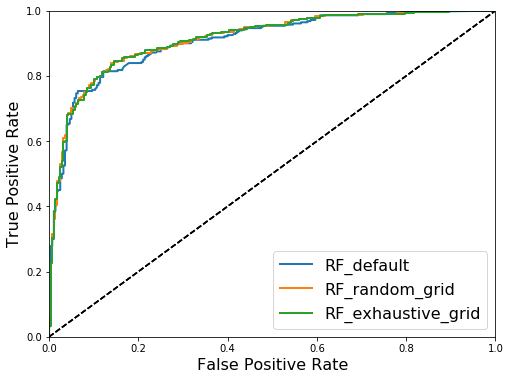

In [25]:
from sklearn.metrics import precision_recall_curve,roc_curve

#pr_sgd, rec_sgd, thr_sgd = precision_recall_curve(training_label,train_score_SGD)

roc_curve_param = {}
for k,r in training_cross_val_results.items():
    fpr,tpr,thr = roc_curve(training_label,r['score'])
    roc_curve_param[k]={'fpr':fpr,'tpr':tpr,'thr':thr}


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    
#plt.figure(figsize=(8, 4))
#plot_precision_recall_vs_threshold(pr_sgd, rec_sgd, thr_sgd)

plt.figure(figsize=(8, 6))
for k,r in roc_curve_param.items():
    plot_roc_curve(r['fpr'],r['tpr'],k)
plt.legend(loc="lower right", fontsize=16)
plt.show()